# Programming a trading bot with Python and the Coinbase Web API 

<b>Summerschool Bayonne 2024</b><br><br>
<b>Author:</b> Dr. Mario Gellrich<br>
<b>Last update:</b> 2024-07-01<br><br>
<font><b>Please note that this trading bot is experimental and for teaching purposes only!</b></font><br><br>

<b>Prerequisites:</b><br> 
- Account on Coinbase: https://www.coinbase.com<br>
  Menu -> Individuals -> Buy and sell -> register<br><br>
- Access to Coinbase Pro's public sandbox: https://public.sandbox.exchange.coinbase.com<br>
  Note that the login sessions and API keys of the sandbox are separate from production.<br><br>

<b>Further reading:</b><br>
- https://github.com/polakowo/vectorbt<br>
- https://blog.devgenius.io/algorithmic-trading-backtesting-a-strategy-in-python-3a136be16ece

## Libraries and settings

In [45]:
# Libraries
import os
import ta
import time
import json
import numpy as np
import pandas as pd
import vectorbt as vbt
from pathlib import Path
import coinbasepro as cbp
from datetime import datetime
import matplotlib.pyplot as plt

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: u:\Lektionen\Summerschool_FS2023\Trading_Bot


## Authentication on Coinbase Pro public sandbox environment

In [48]:
# Public client
client = cbp.PublicClient()

# Sandbox api keys and url
credentials = json.loads(Path('credentials.json').read_text())['sandbox']
API_KEY = credentials.get('api_key')
API_PASS = credentials.get('passphrase')
API_SECRET = credentials.get('secret')
api_url = 'https://api-public.sandbox.pro.coinbase.com'

# Authenticated client
auth_client = cbp.AuthenticatedClient(key=API_KEY,
                                      secret=API_SECRET,
                                      passphrase=API_PASS,
                                      api_url=api_url)

# Show account details
def balance():
    balance_list = []
    for i in auth_client.get_accounts():
        balance_list.append(i.get('currency'))
        balance_list.append(i.get('balance'))
    balance_list

    # Split the data into pairs of (currency, value)
    pairs = [(balance_list[i], balance_list[i+1]) for i in range(0, len(balance_list), 2)]

    # Create a data frame
    df_balance = pd.DataFrame(pairs, columns=['Currency', 'Value'])
    df_balance['Value'] = df_balance['Value'].astype('int')

    # Print currencies with values > 0
    return df_balance.loc[df_balance['Value'] > 0]

# Funcion call
balance()


,Currency,Value
1,BTC,100036
3,EUR,5638966
6,USD,128194


## Making a buy order

In [46]:
# Buy order
auth_client.place_order(product_id = 'BTC-EUR',
                        side = 'buy',
                        order_type = 'market',
                        size = '1')

{'id': 'f401b95a-84df-41a5-8bd2-462b17833126',
 'size': Decimal('1'),
 'product_id': 'BTC-EUR',
 'side': 'buy',
 'stp': 'dc',
 'funds': '5631257.77383078',
 'type': 'market',
 'post_only': False,
 'created_at': datetime.datetime(2024, 3, 8, 14, 14, 32, 176979),
 'fill_fees': Decimal('0'),
 'filled_size': Decimal('0'),
 'executed_value': Decimal('0'),
 'status': 'pending',
 'settled': False}

## Making a sell order

In [29]:
# Sell order
auth_client.place_order(product_id = 'BTC-EUR',
                        side = 'sell',
                        order_type = 'market',
                        size = '1')

{'id': '3da16d51-ac97-47a3-a0ff-9a8f9607c3cc',
 'size': Decimal('1'),
 'product_id': 'BTC-EUR',
 'side': 'sell',
 'stp': 'dc',
 'type': 'market',
 'post_only': False,
 'created_at': datetime.datetime(2024, 3, 8, 14, 6, 48, 587459),
 'fill_fees': Decimal('0'),
 'filled_size': Decimal('0'),
 'executed_value': Decimal('0'),
 'status': 'pending',
 'settled': False}

## Get data

In [49]:
# Function to get data
def get_data(symbol, start, stop, granularity):

    # Server request
    data = client.get_product_historic_rates(product_id=symbol, 
                                             start=start,
                                             stop=stop, 
                                             granularity=granularity)
    
    # Store data in a data frame
    df = pd.DataFrame(data, columns=['time', 
                                     'low', 
                                     'high', 
                                     'open', 
                                     'close', 
                                     'volume'])
    df['Date'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('Date')
    df.drop('time', inplace=True, axis=1)
    df = df.sort_values('Date', ascending=True)
    df.columns = df.columns.str.capitalize()

    # Change data types for calculations
    df['Low'] = df['Low'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Open'] = df['Open'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    
    return df

# Function call to get daily data
df = get_data(symbol = 'BTC-USD', 
              start = '2023-10-01',
              stop = datetime.now().strftime("%Y-%m-%d"),
              granularity = 86400)
df

,Low,High,Open,Close,Volume
Date,,,,,
2023-10-01,26955.25,28062.62,26961.00,27995.46,8747.068888
2023-10-02,27302.30,28613.37,27995.46,27504.04,25148.253419
2023-10-03,27160.47,27672.12,27504.03,27428.96,14334.108576
2023-10-04,27208.65,27842.38,27428.96,27786.75,10238.170534
2023-10-05,27358.05,28140.00,27786.12,27412.96,14136.045928
...,...,...,...,...,...
2024-03-04,62300.00,68602.98,63155.74,68360.14,40600.366569
2024-03-05,59224.68,69324.58,68356.70,63800.78,65575.095373
2024-03-06,62832.39,67654.06,63802.15,66122.28,34653.878846


## Explore the data

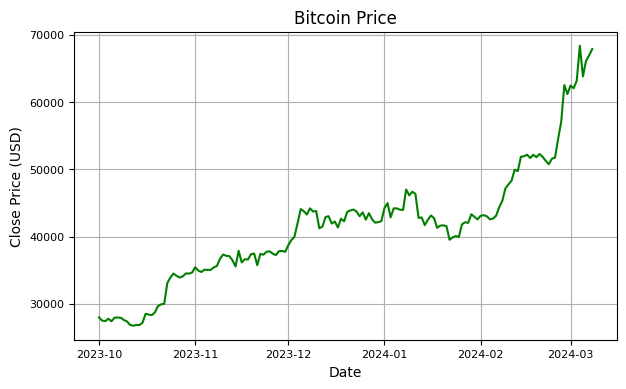

In [50]:
# Plot time-series
plt.figure(figsize=(7, 4))
plt.plot(df['Close'], color='#008000')
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

plt.show()

## Technical analysis

### Simple Moving Average (SMA)

In [51]:
# Calculate different SMA by using different moving windows
df['Fast_SMA'] = ta.trend.sma_indicator(close=df['Close'], window=10)
df['Slow_SMA'] = ta.trend.sma_indicator(close=df['Close'], window=50)
df

,Low,High,Open,Close,Volume,Fast_SMA,Slow_SMA
Date,,,,,,,
2023-10-01,26955.25,28062.62,26961.00,27995.46,8747.068888,NaN,NaN
2023-10-02,27302.30,28613.37,27995.46,27504.04,25148.253419,NaN,NaN
2023-10-03,27160.47,27672.12,27504.03,27428.96,14334.108576,NaN,NaN
2023-10-04,27208.65,27842.38,27428.96,27786.75,10238.170534,NaN,NaN
2023-10-05,27358.05,28140.00,27786.12,27412.96,14136.045928,NaN,NaN
...,...,...,...,...,...,...,...
2024-03-04,62300.00,68602.98,63155.74,68360.14,40600.366569,59460.726,48223.0180
2024-03-05,59224.68,69324.58,68356.70,63800.78,65575.095373,60683.739,48649.2304
2024-03-06,62832.39,67654.06,63802.15,66122.28,34653.878846,62122.867,49109.0670


### Relative Strength Index (RSI)

In [52]:
# Calculate the RSI
df['RSI'] = ta.momentum.rsi(close=df['Close'], window=20)
df

,Low,High,Open,Close,Volume,Fast_SMA,Slow_SMA,RSI
Date,,,,,,,,
2023-10-01,26955.25,28062.62,26961.00,27995.46,8747.068888,NaN,NaN,NaN
2023-10-02,27302.30,28613.37,27995.46,27504.04,25148.253419,NaN,NaN,NaN
2023-10-03,27160.47,27672.12,27504.03,27428.96,14334.108576,NaN,NaN,NaN
2023-10-04,27208.65,27842.38,27428.96,27786.75,10238.170534,NaN,NaN,NaN
2023-10-05,27358.05,28140.00,27786.12,27412.96,14136.045928,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-03-04,62300.00,68602.98,63155.74,68360.14,40600.366569,59460.726,48223.0180,83.226566
2024-03-05,59224.68,69324.58,68356.70,63800.78,65575.095373,60683.739,48649.2304,69.985939
2024-03-06,62832.39,67654.06,63802.15,66122.28,34653.878846,62122.867,49109.0670,72.344110


### Bollinger Bands

In [53]:
# Calculate the Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)

# Extract the upper, middle, and lower bands
upper_band = bollinger.bollinger_hband()
middle_band = bollinger.bollinger_mavg()
lower_band = bollinger.bollinger_lband()

# Add the bands to the DataFrame
df['Upper_BBand'] = upper_band
df['Middle_BBand'] = middle_band
df['Lower_BBand'] = lower_band
df

,Low,High,Open,Close,Volume,Fast_SMA,Slow_SMA,RSI,Upper_BBand,Middle_BBand,Lower_BBand
Date,,,,,,,,,,,
2023-10-01,26955.25,28062.62,26961.00,27995.46,8747.068888,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-02,27302.30,28613.37,27995.46,27504.04,25148.253419,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-03,27160.47,27672.12,27504.03,27428.96,14334.108576,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-04,27208.65,27842.38,27428.96,27786.75,10238.170534,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-05,27358.05,28140.00,27786.12,27412.96,14136.045928,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,62300.00,68602.98,63155.74,68360.14,40600.366569,59460.726,48223.0180,83.226566,66295.352820,55615.2310,44935.109180
2024-03-05,59224.68,69324.58,68356.70,63800.78,65575.095373,60683.739,48649.2304,69.985939,67312.656497,56212.3405,45112.024503
2024-03-06,62832.39,67654.06,63802.15,66122.28,34653.878846,62122.867,49109.0670,72.344110,68634.342682,56921.7400,45209.137318


## Plot technical indicators

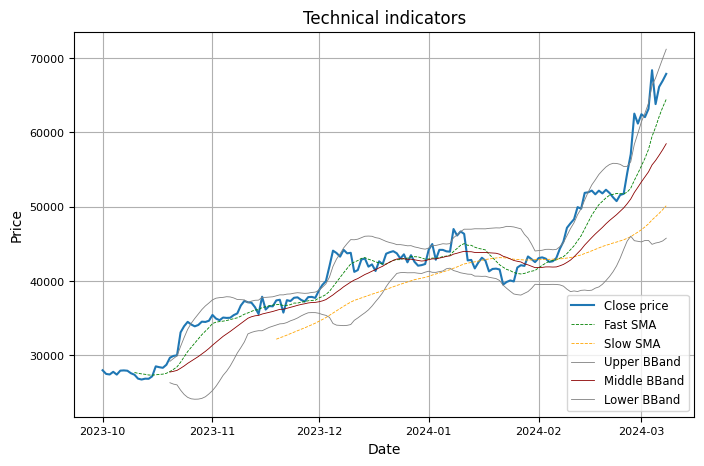

In [54]:
# Plotting the close price
plt.figure(figsize=(8, 5))
plt.plot(df['Close'], label='Close price', linewidth=1.5)

# Plotting the technical indicators
plt.plot(df['Fast_SMA'], label='Fast SMA', linewidth=0.6, color='green', linestyle='--')
plt.plot(df['Slow_SMA'], label='Slow SMA', linewidth=0.6, color='orange', linestyle='--')
plt.plot(df['Upper_BBand'], label='Upper BBand', linewidth=0.6, color='gray')
plt.plot(df['Middle_BBand'], label='Middle BBand', linewidth=0.6, color='darkred')
plt.plot(df['Lower_BBand'], label='Lower BBand', linewidth=0.6, color='gray')

# Set the chart title and labels
plt.title('Technical indicators')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)

# Settings for ticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Add a grid
plt.grid()

# Add a legend
plt.legend(loc='lower right', fontsize='small')

# Display the chart
plt.show()

## Defining the trading strategy

### Moving Average Crossover Strategy

In [55]:
# We use the Moving Average Crossover Strategy as trading strategy. The logic is as follows:
# A crossover occurs when a faster moving average (i.e. a shorter period moving average) of
# closing prices crosses a slower moving average (i.e. a longer period moving average). When 
# the fast moving average crosses above the slow moving average, it is a buying signal. When 
# it crosses below, it is a selling signal.

class MovingAverageCrossStrategy():
    '''
    Creates signals and positions for the Moving Average Crossover strategy
    param: data: name of the data set. Type = DataFrame
    param: short_sma: size moving window for short SMA in days. Type = int
    param: long_sma: size moving window for long SMA in days. Type = int
    param: cop: cross-over points only (True) or position (False). Type = bool

    returns: signals, moving averages (short, long) and positions. Type = DataFrame
    '''
    def __init__(self, data, fast_sma, slow_sma):
        self.data = data
        self.fast_sma = fast_sma
        self.slow_sma = slow_sma

    def generate_signals(self):
        # Initialize the signals vector
        signals = pd.DataFrame(index=self.data.index)

        # Create short and long simple moving averages
        fast_sma = vbt.MA.run(self.data['Close'], self.fast_sma, short_name='fast')
        slow_sma = vbt.MA.run(self.data['Close'], self.slow_sma, short_name='slow')
        
        signals['Close'] = self.data['Close']
        
        signals['Fast_SMA'] = ta.trend.sma_indicator(close=self.data['Close'], window=self.fast_sma)
        signals['Slow_SMA'] = ta.trend.sma_indicator(close=self.data['Close'], window=self.slow_sma)

        # Create entries and exits
        signals['Entries'] = fast_sma.ma_crossed_above(slow_sma).astype(int)
        signals['Exits'] = fast_sma.ma_crossed_below(slow_sma).astype(int)

        return signals


### Apply the Moving Average Crossover Strategy to the data

In [56]:
# Create class instance
obj = MovingAverageCrossStrategy(df, 10, 50)

# Call class method to create signals
signals = obj.generate_signals()

# Show signals for entries and exits
signals.loc[(signals['Entries'] != 0) | (signals['Exits'] != 0)]

,Close,Fast_SMA,Slow_SMA,Entries,Exits
Date,,,,,
2024-01-20,41666.67,42659.669,43101.5334,0,1
2024-02-07,44343.61,43073.380,42988.2994,1,0


### Plot entry- and exit points

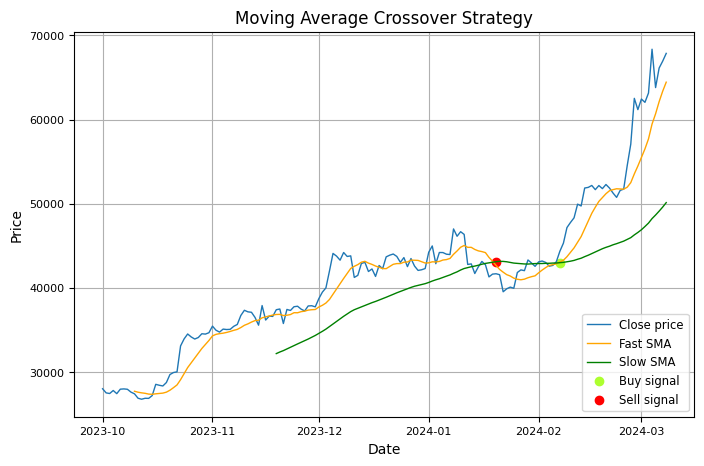

In [57]:
def plot_signals():

    # Plot prices
    plt.figure(figsize=(8, 5))
    plt.plot(signals['Close'], label='Close price', linewidth=1)
    plt.plot(signals['Fast_SMA'], label='Fast SMA', linewidth=1, color='orange')
    plt.plot(signals['Slow_SMA'], label='Slow SMA', linewidth=1, color='green')

    # Show crossover points
    cp_buy = signals[signals['Entries'] == 1]
    cp_sell = signals[signals['Exits'] == 1]
    plt.scatter(cp_buy.index, cp_buy['Slow_SMA'], color='greenyellow', label='Buy signal')
    plt.scatter(cp_sell.index, cp_sell['Slow_SMA'], color='red', label='Sell signal')

    # Set the chart title and labels
    plt.title('Moving Average Crossover Strategy')
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Settings for ticks
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add a grid
    plt.grid()

    # Add a legend
    plt.legend(loc='lower right', fontsize='small')
    
    plt.show()


# Function call
plot_signals()


## Backtesting the trading strategy

### Backtesting statistics

In [59]:
# Backtesting statistics:
# Benchmark Return [%] = Buy & Hold return
# Total Return [%] = strategy return

# We invested 10,000 EUR, and assumed fees of 0.1% per trade
pf = vbt.Portfolio.from_signals(signals['Close'], 
                                signals['Entries'], 
                                signals['Exits'], 
                                fees=0.001, 
                                init_cash=10000)
pf.stats()

Start                         2023-10-01 00:00:00
End                           2024-03-08 00:00:00
Period                          160 days 00:00:00
Start Value                               10000.0
End Value                            15289.080591
Total Return [%]                        52.890806
Benchmark Return [%]                   142.414663
Max Gross Exposure [%]                      100.0
Total Fees Paid                           9.99001
Max Drawdown [%]                         6.669618
Max Drawdown Duration             5 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                        5289.080591
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


### Backtesting graphics

#### Positions and cumulated returns

In [40]:
pf.plot_positions().show()
pf.plot_cum_returns().show()

### Optimizing the fast and slow SMA values for strategy

#### Heatmap with range of fast and slow SMA values and related returns

In [62]:
# Get data from Yahoo Finance
symbols = ["BTC-EUR", "BTC-USD"]
price = vbt.YFData.download(symbols, 
                            missing_index='drop', 
                            start='2023-10-01').get('Close')

# Moving averages
windows = np.arange(2, 101)
fast_ma, slow_ma = vbt.MA.run_combs(price, 
                                    window=windows,
                                    r=2, 
                                    short_names=['fast', 'slow'])
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)

# Calculation of returns
pf_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
pf = vbt.Portfolio.from_signals(price, entries, exits)

# Show slow and fast SMA providing the highest return (in EUR)
df_optim = pd.DataFrame(pf.total_return(), columns=['total_return']).reset_index()
df_optim_sub = df_optim.loc[df_optim['symbol'] == 'BTC-EUR']
print('Fast and slow SMA with related optimal return:')
print(df_optim_sub.loc[df_optim_sub['total_return'] == max(df_optim_sub['total_return'])])

# Figure
fig = pf.total_return().vbt.heatmap(x_level='fast_window', 
                                    y_level='slow_window', 
                                    slider_level='symbol', 
                                    symmetric=True,
    trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='%')))
fig.show()


Fast and slow SMA with related optimal return:
      fast_window  slow_window   symbol  total_return
1168            8           20  BTC-EUR      1.226274


### Returns with optimized parameters

In [63]:
# New instance
obj = MovingAverageCrossStrategy(df, 48, 53)
signals = obj.generate_signals()
signals.loc[(signals['Entries'] != 0) | (signals['Exits'] != 0)]

# Backtesting
pf = vbt.Portfolio.from_signals(signals['Close'], 
                                signals['Entries'], 
                                signals['Exits'], 
                                fees=0.001, 
                                init_cash=10000)

# Graphics
pf.plot_positions().show()
pf.plot_cum_returns().show()

# Backtesting statistics
pf.stats()

Start                         2023-10-01 00:00:00
End                           2024-03-08 00:00:00
Period                          160 days 00:00:00
Start Value                               10000.0
End Value                            14293.462429
Total Return [%]                        42.934624
Benchmark Return [%]                   142.414663
Max Gross Exposure [%]                      100.0
Total Fees Paid                         31.048137
Max Drawdown [%]                         6.669618
Max Drawdown Duration             5 days 00:00:00
Total Trades                                    2
Total Closed Trades                             1
Total Open Trades                               1
Open Trade PnL                        3764.409554
Win Rate [%]                                100.0
Best Trade [%]                           5.295819
Worst Trade [%]                          5.295819
Avg Winning Trade [%]                    5.295819
Avg Losing Trade [%]                          NaN


## Running the trading bot to buy and sell the BTC-EUR pair

In [64]:
def run_trading_bot(symbol, start, stop, granularity, fast_sma, slow_sma):
        
    while True:

        # Get current data
        data = get_data(symbol = symbol, 
                        start = start,
                        stop = stop,
                        granularity = granularity)
        
        # Get signals
        smacross = MovingAverageCrossStrategy(data, fast_sma, slow_sma)
        strategy = smacross.generate_signals()

        # Get current balance
        bal_all = balance()
        bal_btc = int(bal_all.loc[bal_all['Currency'] == 'BTC']['Value'])
        bal_eur = int(bal_all.loc[bal_all['Currency'] == 'EUR']['Value'])

        # Apply trading strategy
        if strategy['Entries'][-1] == 1 and bal_btc > 0 and bal_eur > 0:
            print(f"Current balance: BTC: {bal_btc}, EUR: {bal_eur}")
            try:
                auth_client.place_order(product_id = symbol,
                            side = 'buy',
                            order_type = 'market',
                            size = '1')
                print('Buy signal from strategy: Placed buy order!')
            except:
                print('Please check your balance!')

        elif strategy['Exits'][-1] == 1 and bal_btc > 0 and bal_eur > 0:
            print(f"Current balance: BTC: {bal_btc}, EUR: {bal_eur}")
            try:
                auth_client.place_order(product_id = symbol,
                            side = 'sell',
                            order_type = 'market',
                            size = '1')
                print('Sell signal from strategy: Placed sell order!')
            except:
                print('Please check your balance!')
            
        else:
            print(f"Bot is waiting for buy or sell signal!")

        # Wait until the next order is placed
        time.sleep(60)

# Run the trading bot with the optimized values for short_sma & long_sma
today = datetime.now().strftime('%Y-%m-%d')
# run_trading_bot('BTC-EUR', '2023-10-01', today, 86400, 48, 53)

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [44]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2024-03-08 15:06:51
Python Version: 3.10.11
-----------------------------------
